In [2]:
import gym
import numpy as np
import time
import os
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [223]:
plt.style.context("ggplot")

In [3]:
env = gym.make('CliffWalking-v0')

In [79]:
def get_action(Q, state, eps, train):
        if not train:
            return np.argmax(Q[state])
        
        
        if np.random.random() >= eps:
            return np.argmax(Q[state])
        else:
            return np.random.randint(0, 4)
            
            

# N - Step Sarsa

In [332]:
def n_step_sarsa(n_episodes, n, gamma , eps, alpha):
    terminal = list(range(37,48))
    Q = np.ones((env.nS, env.nA))*5
    
    STATS = {
        "rewards_sum": [],
        "episode_length": [],
        "rmse": []
    }
    
    for i in terminal:
            Q[i] = np.array([0, 0, 0, 0])
    
    for episode in range(n_episodes):    
        s = env.reset()
        T = float('inf')
        Tau = 0
        t = 0
        
        S = [0]*(n+1)
        R = [0]*(n+1)
        A = [0]*(n+1)
        
        S[0] = s
        
        
        reward_sum = 0
        error = 0
        action = get_action(Q, s, eps, True)
        A[t] = action
        while Tau != T - 1:
            
            if t < T:
                
                
                next_state, reward, done, _ = env.step(A[t%(n+1)])
                
                R[(t+1)%(n+1)] = reward
                S[(t+1)%(n+1)] = next_state
                s = next_state
                
                
                
                reward_sum+= reward
                
                
                if done:
                    T = t+1
                    STATS["episode_length"].append(t)
                    STATS["rewards_sum"].append(reward_sum)
                else:
                    next_action = get_action(Q, s, eps, True )
                    A[(t+1)%(n+1)] = next_action
                    
                
            Tau = t - n + 1
            
            if Tau >= 0:
                G = sum([gamma**(k-Tau-1)*R[(k)%(n+1)]for k in range(Tau+1, min(Tau+n, T))])
                if Tau + n < T:
                    G = G + gamma**(n)*Q[S[(Tau+n)%(n+1)],A[(Tau+n)%(n+1)]]
                    
                error =error+ (G - Q[S[Tau%(n+1)], A[Tau%(n+1)]])**2
                Q[S[Tau%(n+1)], A[Tau%(n+1)]]+= alpha*(G - Q[S[Tau%(n+1)], A[Tau%(n+1)]])
            t+=1
        STATS["rmse"].append((error/t)**(0.5))
    return Q, STATS

In [333]:
Q, stats = n_step_sarsa(500, 7,1.0, 0.2, 0.01)

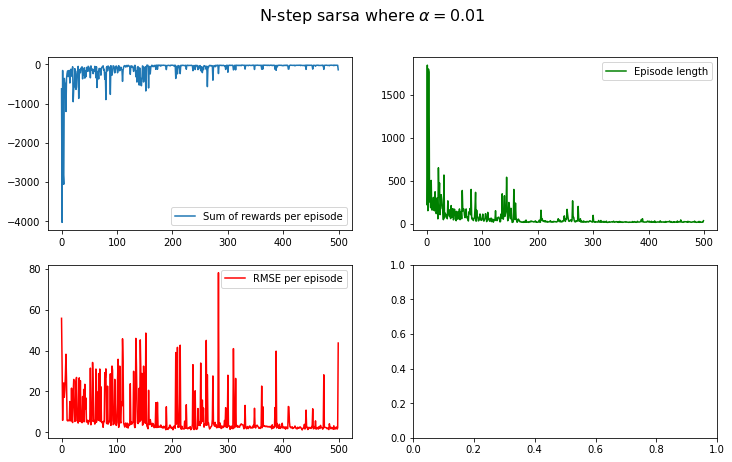

In [334]:
fig, axs = plt.subplots(2,2, figsize=(12,7))
fig.suptitle("N-step sarsa where $ \\alpha = 0.01 $", fontsize=16)

axs[0][0].plot(stats["rewards_sum"], label="Sum of rewards per episode")
axs[0][1].plot(stats["episode_length"], label="Episode length", color="g")
axs[1][0].plot(stats["rmse"], label="RMSE per episode", color="r")
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()

In [345]:
Q, stats = n_step_sarsa(500, 5,1.0, 0.2, 0.1)

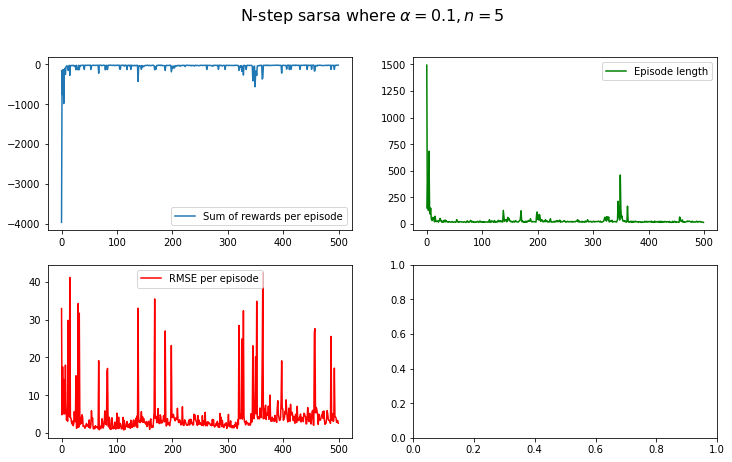

In [346]:
fig, axs = plt.subplots(2,2, figsize=(12,7))
fig.suptitle("N-step sarsa where $ \\alpha = 0.1, n=5 $", fontsize=16)

axs[0][0].plot(stats["rewards_sum"], label="Sum of rewards per episode")
axs[0][1].plot(stats["episode_length"], label="Episode length", color="g")
axs[1][0].plot(stats["rmse"], label="RMSE per episode", color="r")
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()

In [337]:
# smaller Q is much better

In [338]:
Q, stats = n_step_sarsa(500, 5,1.0, 0.2, 0.0001)

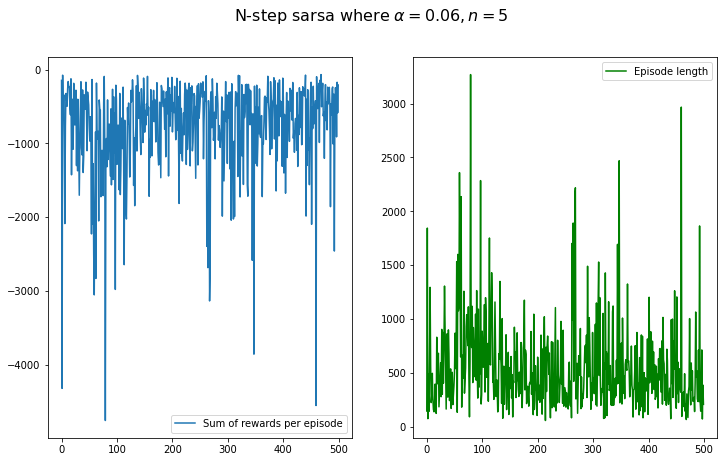

In [339]:
fig, axs = plt.subplots(1,2, figsize=(12,7))
fig.suptitle("N-step sarsa where $ \\alpha = 0.06, n=5 $", fontsize=16)

axs[0].plot(stats["rewards_sum"], label="Sum of rewards per episode")
axs[1].plot(stats["episode_length"], label="Episode length", color="g")
axs[0].legend()
axs[1].legend()

In [591]:
def demo_policy(control, limit=30):
    env.reset()
    out = env.render(mode="ansi")
    done = False
    s = env.reset()
    i = 0
    while not done:
        
        s_, r, done, prop = env.step(np.argmax(Q[s]))
        time.sleep(0.5)
        clear_output()
        print(env.render())
        s = s_
        i+=1
        if i >= limit:
            done = True
    

In [341]:
def get_lr_stats(n_step_sarsa, alphas, n_episodes=20, n_steps=5):
    rmse_avg = []
   

    for alpha in alphas:

        t = time.time()

        Q, stats = n_step_sarsa(n_episodes, n_steps,1.0, 0.2, alpha)
        rmse_avg.append(np.mean(stats['rmse']))
#         print("{:.2f}".format(time.time()-t))
    return rmse_avg
    

In [342]:
alpha_stats = get_lr_stats(n_step_sarsa, np.linspace(0.00000001,1, 25 ),n_steps=3)

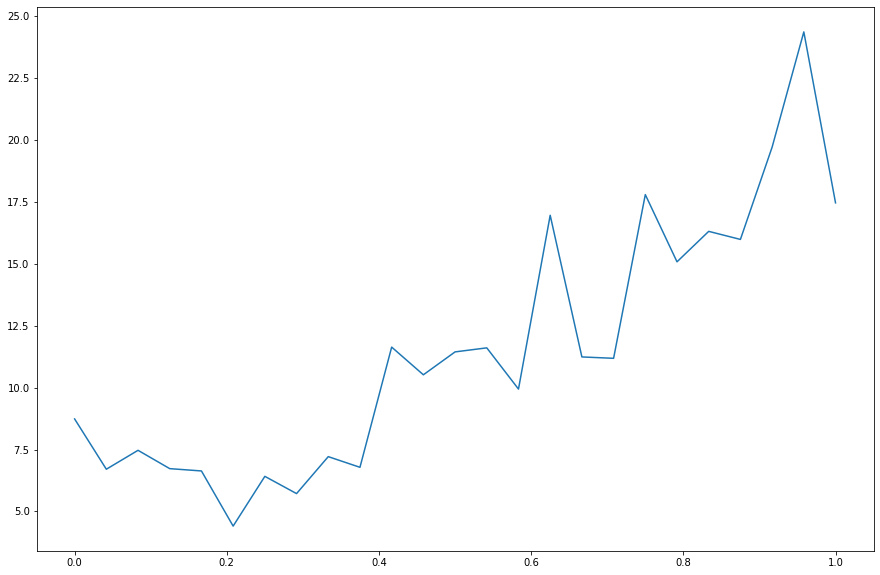

In [343]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(0.00000001,1, 25 ),alpha_stats, label="RMSE Average related to $\\alpha$")

In [347]:
demo_policy(Q, limit=25)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

None


In [190]:
Q[36]

array([-202.7684933 , -599.65644897, -191.80454391, -261.12501763])

In [136]:
env.reset()
env.step(0)

(24, -1, False, {'prob': 1.0})

In [479]:
def behavior_probs(S, Q, eps=0.2):
#         return probabilities for each action
    
    probs = np.ones(env.nA)*(eps/env.nA)
    probs[np.argmax(Q[S])] +=1-eps
    return probs

In [480]:
def normalize_q_values(q_values, temperature=1.0):
    # Apply softmax function to Q-values using the given temperature
    exp_q_values = np.exp(q_values / temperature)
    
    # Normalize probabilities to sum to 1
    sum_exp_q_values = np.sum(exp_q_values)
    if sum_exp_q_values < 1e-10:
        # Avoid divide-by-zero error by returning equal probabilities
        prob_values = np.ones_like(q_values) / len(q_values)
    else:
        prob_values = exp_q_values / sum_exp_q_values
    
    return prob_values

In [490]:
def target_probs(S,Q, eps=0.0):
#     lets just use softmax
# tau = temperature for approximate softmax
    probs = np.ones(env.nA)*(eps/env.nA)
    probs[np.argmax(Q[S])] +=1-eps
    return probs
    

In [491]:
behavior_probs(36, Q, eps=0.3).sum()

0.9999999999999998

In [492]:
target_probs(36, Q)

array([1., 0., 0., 0.])

In [416]:
probs = behavior(3,Q)

In [417]:
def choose_from_probs(probs):
    return np.random.choice(np.arange(int(env.nA)), p=probs)

In [421]:
probs

array([0.05, 0.85, 0.05, 0.05])

In [420]:
choose_from_probs(probs)

1

# Off-Policy Learning with importance sampling

In [494]:
def n_step_off_policy(n_episodes, n, gamma , eps, alpha):
    terminal = list(range(37,48))
    Q = np.ones((env.nS, env.nA))*5
    
    STATS = {
        "rewards_sum": [],
        "episode_length": [],
        "rmse": []
    }
    
    for i in terminal:
            Q[i] = np.array([0, 0, 0, 0])
    
    for episode in range(n_episodes):  
        s = env.reset()
        T = float('inf')
        Tau = 0
        t = 0
        
        S = [0]*(n+1)
        R = [0]*(n+1)
        A = [0]*(n+1)
        
        S[0] = s
        
        
        reward_sum = 0
        error = 0
        action = choose_from_probs(behavior_probs(S[t], Q))
        A[t] = action
        while Tau != T - 1:
            
            if t < T:
                
                
                next_state, reward, done, _ = env.step(A[t%(n+1)])
                
                R[(t+1)%(n+1)] = reward
                S[(t+1)%(n+1)] = next_state
                s = next_state
                
                
                
                reward_sum+= reward
                
                
                if done:
                    T = t+1
                    STATS["episode_length"].append(t)
                    STATS["rewards_sum"].append(reward_sum)
                else:
                    next_action = choose_from_probs(behavior_probs(S[t%(n+1)], Q))
                    A[(t+1)%(n+1)] = next_action
                    
                
            Tau = t - n + 1
            
            if Tau >= 0:
                G = sum([gamma**(k-Tau-1)*R[(k)%(n+1)]for k in range(Tau+1, min(Tau+n, T))])
                if Tau + n < T:
                    G = G + gamma**(n)*Q[S[(Tau+n)%(n+1)],A[(Tau+n)%(n+1)]]
                    
                error =error+ (G - Q[S[Tau%(n+1)], A[Tau%(n+1)]])**2
                
                p = np.prod([target_probs(S[k%(n+1)], Q)[A[k%(n+1)]]/behavior_probs(S[k%(n+1)], Q)[A[k%(n+1)]] for k in range(Tau+1, min(Tau+n-1, T-1))])
                Q[S[Tau%(n+1)], A[Tau%(n+1)]]+= alpha*p*(G - Q[S[Tau%(n+1)], A[Tau%(n+1)]])
            t+=1
        STATS["rmse"].append((error/t)**(0.5))
    return Q, STATS

In [495]:
Q, stats = n_step_off_policy(500, 5,1.0, 0.2, 0.01)

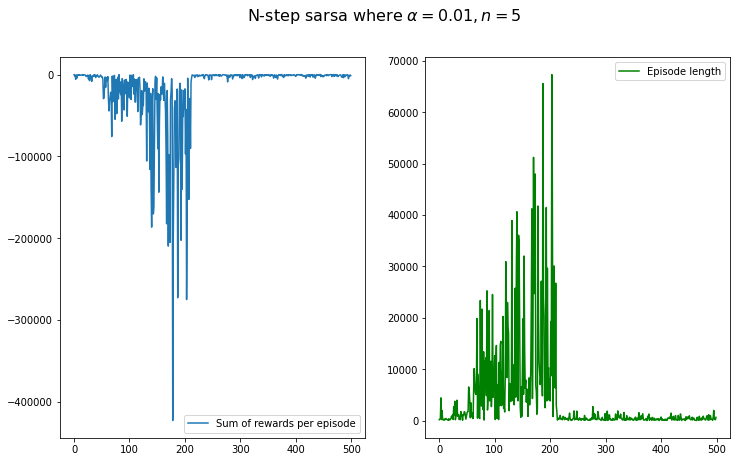

In [496]:
fig, axs = plt.subplots(1,2, figsize=(12,7))
fig.suptitle("N-step sarsa where $ \\alpha = 0.01, n=5 $", fontsize=16)

axs[0].plot(stats["rewards_sum"], label="Sum of rewards per episode")
axs[1].plot(stats["episode_length"], label="Episode length", color="g")
axs[0].legend()
axs[1].legend()

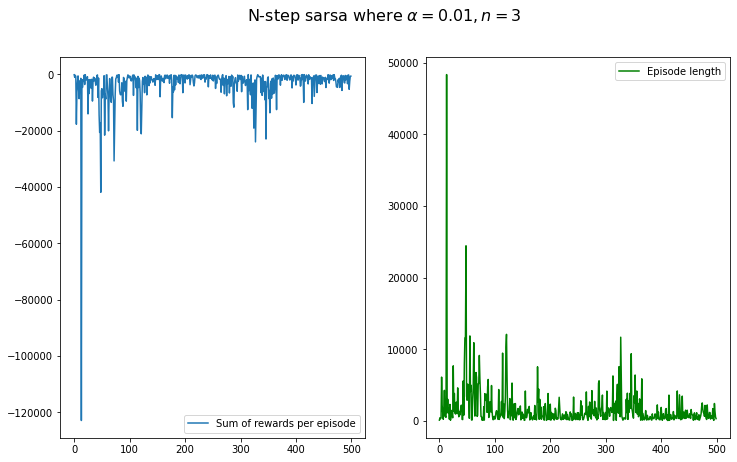

In [498]:
Q, stats = n_step_off_policy(500, 3,1.0, 0.2, 0.01)
fig, axs = plt.subplots(1,2, figsize=(12,7))
fig.suptitle("N-step sarsa where $ \\alpha = 0.01, n=3 $", fontsize=16)

axs[0].plot(stats["rewards_sum"], label="Sum of rewards per episode")
axs[1].plot(stats["episode_length"], label="Episode length", color="g")
axs[0].legend()
axs[1].legend()

# N Step Tree Backup Algorithm

In [515]:
np.random.choice(4)

1

In [615]:
def n_step_tree_backup(n_episodes, n, gamma , eps, alpha):
    terminal = list(range(37,48))
    Q = np.ones((env.nS, env.nA))*5
    G = 0
    STATS = {
        "rewards_sum": [],
        "episode_length": [],
        "rmse": []
    }
    
    for i in terminal:
            Q[i] = np.array([0, 0, 0, 0])
    
    for episode in range(n_episodes):  
        s = env.reset()
        T = float('inf')
        Tau = 0
        t = 0
        
        S = [0]*(n+1)
        R = [0]*(n+1)
        A = np.array([0]*(n+1))
        
        S[0] = s
        
        
        reward_sum = 0
        error = 0
        action = np.random.choice(env.nA)
        A[t] = action
        
        while Tau != T - 1:
            
            if t < T:
                
                
                next_state, reward, done, _ = env.step(A[t%(n+1)])
                
                R[(t+1)%(n+1)] = reward
                S[(t+1)%(n+1)] = next_state
                s = next_state
                
                
                
                reward_sum+= reward
                
                
                if done:
                    T = t+1
                    
                else:
                    next_action = np.random.choice(4)
                    A[(t+1)%(n+1)] = next_action
                    
                
            Tau = t - n + 1
            
            if Tau >= 0:
                if t+1 >=T:
                    G = R[T%(n+1)]
                else:
                    G = R[(t+1)%(n+1)] + gamma* sum(np.array(target_probs(S[(t+1)%(n+1)], Q))*Q[S[(t+1)%(n+1)]])
                
                for k in range(min(t, T-1), Tau+1):
                    _actions = np.delete(np.arange(env.nA), A[k%(n+1)])
                    expected_value = sum((np.array(target_probs(S[(k)%(n+1)], Q))*Q[S[(k)%(n+1)]])[_actions] )
                    G = R[k%(n+1)]+ gamma*expected_value + gamma*target_probs(S[k%(n+1)], Q)[A[k%(n+1)]]*G
                Q[S[Tau%(n+1)], A[Tau%(n+1)]]+= alpha*(G - Q[S[Tau%(n+1)], A[Tau%(n+1)]])
            t+=1
            
            
                
        r_sum , ep_len = evaluateQ(Q)
        STATS["episode_length"].append(ep_len)
        STATS["rewards_sum"].append(r_sum)
        
        STATS["rmse"].append((error/t)**(0.5))
    return Q, STATS

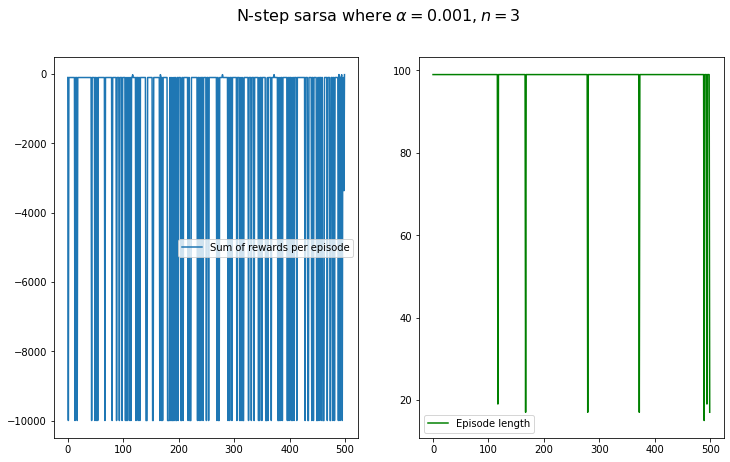

In [619]:
Q, stats = n_step_tree_backup(500, 8,1.0, 0.2, 0.1)
fig, axs = plt.subplots(1,2, figsize=(12,7))
fig.suptitle("N-step sarsa where $ \\alpha = 0.001, n=3 $", fontsize=16)

axs[0].plot(stats["rewards_sum"], label="Sum of rewards per episode")
axs[1].plot(stats["episode_length"], label="Episode length", color="g")
axs[0].legend()
axs[1].legend()

In [620]:
def evaluateQ(Q, limit=100):
    env.reset()
    out = env.render(mode="ansi")
    done = False
    s = env.reset()
    i = 0
    
    reward_sum = 0
    while not done:
        s_, r, done, prop = env.step(np.argmax(Q[s]))
        s = s_
        i+=1
        if i >= limit:
            i-=1
            done = True
            
        reward_sum+=r
    
    return reward_sum, i

In [622]:
demo_policy(Q, limit=25)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

None



# n-step Q($\sigma$)

In [623]:
def behavior_probs(S, Q, eps=0.2):
#         return probabilities for each action
    
    probs = np.ones(env.nA)*(eps/env.nA)
    probs[np.argmax(Q[S])] +=1-eps
    return probs

In [624]:
def choose_from_probs(probs):
    return np.random.choice(np.arange(int(env.nA)), p=probs)

In [643]:
def target_probs(S,Q, eps=0.0):
#     lets just use softmax
# tau = temperature for approximate softmax
    probs = np.ones(env.nA)*(eps/env.nA)
    probs[np.argmax(Q[S])] +=1-eps
    return probs
    

In [669]:
def n_step_q_sigma(n_episodes, n, gamma , eps, alpha):
    terminal = list(range(37,48))
    Q = np.ones((env.nS, env.nA))*5
    G = 0
    STATS = {
        "rewards_sum": [],
        "episode_length": [],
        "rmse": []
    }
    
    for i in terminal:
            Q[i] = np.array([0]*(env.nA))
    
    for episode in range(n_episodes):  
        s = env.reset()
        T = float('inf')
        Tau = 0
        t = 0
#         STORES
        S = [0]*(n+1)
        R = [0]*(n+1)
        SIGMA = [0]*(n+1)        
        A = [0]*(n+1)
        RHO = [0]*(n+1)
        
        S[0] = s
        
        
        reward_sum = 0
        error = 0
        action = choose_from_probs(behavior_probs(S[0],Q, eps = eps))
        A[t] = action
        
        while Tau != T - 1:
            
            if t < T:
                
                
                next_state, reward, done, _ = env.step(A[t%(n+1)])
                
                R[(t+1)%(n+1)] = reward
                S[(t+1)%(n+1)] = next_state
                s = next_state
                
                
                
                reward_sum+= reward
                
                
                if done:
                    T = t+1
                    STATS["episode_length"].append(t)
                    STATS["rewards_sum"].append(reward_sum)
                else:
                    next_action = choose_from_probs(behavior_probs(S[(t+1)%(n+1)],Q, eps = eps))
                    A[(t+1)%(n+1)] = next_action
                    SIGMA[(t+1)%(n+1)] = np.random.randint(0,2)
                    RHO[(t+1)%(n+1)] = target_probs(S[(t+1)%(n+1)], Q, eps=0.0)/behavior_probs(S[(t+1)%(n+1)], Q, eps=eps)
                
            Tau = t - n + 1
            
            if Tau >= 0:
                G = 0
                if t+1 >=T:
                    pass
                else:
                    G = R[(t+1)%(n+1)] + gamma* sum(np.array(target_probs(S[(t+1)%(n+1)], Q))*Q[S[(t+1)%(n+1)]])
                
                for k in range(min(t+1, T), Tau+1):
                    if k == T:
                        G = R[T%(n+1)]
                    else :
                        expected_value = sum((np.array(target_probs(S[(k)%(n+1)], Q))*Q[S[(k)%(n+1)]]) )
                        control = SIGMA[k%(n+1)]*RHO[k%(n+1)] + (1-RHO[k%(n+1)])*target_probs(S[k%(n+1)], Q)[A[k%(n+1)]]
                        G = R[k%(n+1)]+ gamma*expected_value + gamma*control*(G - Q[S[k%(n+1)], A[k%(n+1)]])
                Q[S[Tau%(n+1)], A[Tau%(n+1)]]+= alpha*(G - Q[S[Tau%(n+1)], A[Tau%(n+1)]])
                error =error+ (G - Q[S[Tau%(n+1)], A[Tau%(n+1)]])**2
            t+=1
            
            
                
        r_sum , ep_len = evaluateQ(Q)
#         STATS["episode_length"].append(ep_len)
#         STATS["rewards_sum"].append(r_sum)
        
        STATS["rmse"].append((error/t)**(0.5))
    return Q, STATS

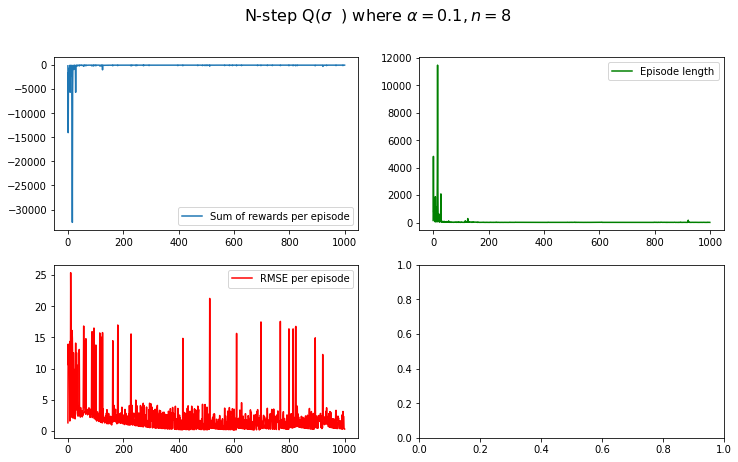

In [665]:
Q, stats = n_step_q_sigma(1000, 7,1.0, 0.1, 0.02)
fig, axs = plt.subplots(2,2, figsize=(12,7))
fig.suptitle("N-step Q($\sigma$  ) where $ \\alpha = 0.1, n=8 $", fontsize=16)
axs[0][0].plot(stats["rewards_sum"], label="Sum of rewards per episode")
axs[0][1].plot(stats["episode_length"], label="Episode length", color="g")
axs[1][0].plot(stats["rmse"], label="RMSE per episode", color="r")
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()

In [666]:
demo_policy(Q, limit=25)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

None


In [670]:
env = gym.make("Taxi-v3")

In [703]:
def get_moving_avg(arr, window_size=10):
    M = [arr[0]]
    for i in range(1, len(arr)-window_size):
        M.append(np.mean(arr[i:min(i+window_size, len(arr)-1)]))
    return M
    

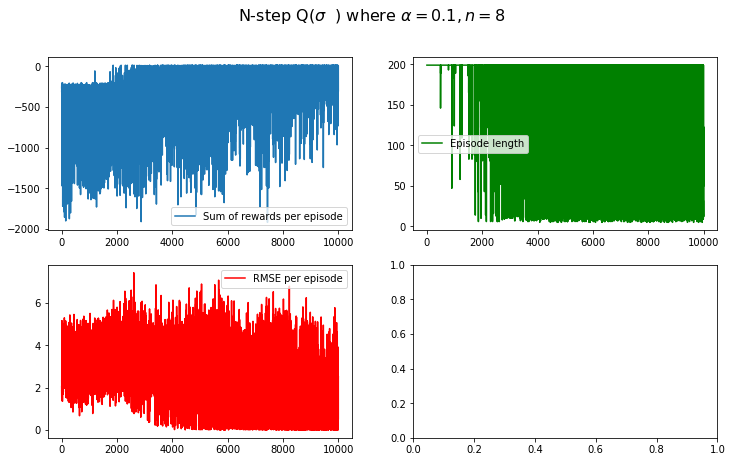

In [711]:
# Q, stats = n_step_q_sigma(10000, 35,1.0, 0.05, 0.05)
fig, axs = plt.subplots(2,2, figsize=(12,7))
fig.suptitle("N-step Q($\sigma$  ) where $ \\alpha = 0.1, n=8 $", fontsize=16)
axs[0][0].plot(stats["rewards_sum"], label="Sum of rewards per episode")
axs[0][1].plot(stats["episode_length"], label="Episode length", color="g")
axs[1][0].plot(stats["rmse"], label="RMSE per episode", color="r")
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()

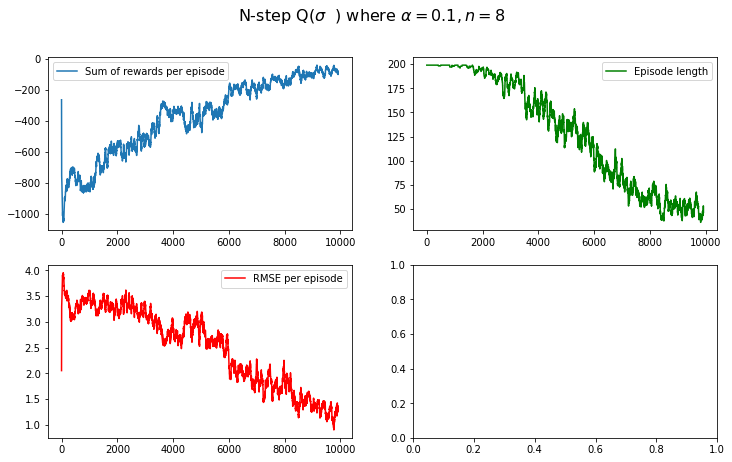

In [712]:
# Q, stats = n_step_q_sigma(10000, 35,1.0, 0.05, 0.05)
fig, axs = plt.subplots(2,2, figsize=(12,7))
fig.suptitle("N-step Q($\sigma$  ) where $ \\alpha = 0.1, n=8 $", fontsize=16)
axs[0][0].plot(get_moving_avg(stats["rewards_sum"], window_size=80), label="Sum of rewards per episode")
axs[0][1].plot(get_moving_avg(stats["episode_length"], window_size=80), label="Episode length", color="g")
axs[1][0].plot(get_moving_avg(stats["rmse"], window_size=80), label="RMSE per episode", color="r")
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()

In [713]:
demo_policy(Q, limit=250)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
None


In [687]:
env.step(0)

(464, -1, False, {'prob': 1.0})